In [1]:
import numpy as np
import time
from scipy.optimize import differential_evolution, minimize, dual_annealing
import matplotlib.pyplot as plt
import concurrent.futures
import threading

import sys 
sys.path.append("../")  
import minionpy as mpy
import minionpy.test_functions as mpytest
import time

# Minimizing Basic Functions

In this section, we minimize basic functions such as Sphere, Rosenbrock, and Rastrigin. The search space is shifted to prevent algorithms from converging near the origin, as some algorithms tend to favor that region.


In [2]:
def sphere(x) : 
    x =np.asarray(x)-1
    return 100+np.sum(x**2)

def rosenbrock(x):
    x = np.asarray(x)-1.0
    return 100+np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

def rastrigin(x):
    x = np.asarray(x)-1.0
    A = 10
    return 100+A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

#remember that in minion, objective function must be vectorized. Suppose you want to 
func = rosenbrock
def objective_function(X) : 
    """ 
    Here, X is a list of x, where x is an input vector. 
    """
    return [func(x) for x in X] 

#Now minimize the function using minion 
dimension = 5 #set dimension of the problem
maxevals = 10000 #number of function calls
x0 = [3.0]*dimension # initial guess

min = mpy.Minimizer(func=objective_function, x0=x0, bounds=[(-10, 10)]*dimension, algo="ARRDE", relTol=0.0, maxevals=10000, callback=None, seed=None, options=None)
result = min.optimize()
print("The minimum of the function is ", "\n\t x : ", result.x, "\n\t f(x) : ", result.fun)

The minimum of the function is  
	 x :  [2.002611687492847, 2.0053773055195236, 2.0093016488558213, 2.01847029257644, 2.037474271831042] 
	 f(x) :  100.00069369508057


# Using Basic Test Functions

Minionpy provides a variety of test functions for evaluating optimization algorithms. The dictionary `testFunctionDict` below contains some of the fundamental functions available. Many of these functions have a global minimum at the origin, which can be problematic since some algorithms naturally converge toward it. To address this issue, CEC benchmark functions apply rotation and shifting to these basic functions, making them more representative of real-world optimization scenarios.  

The test functions in `minionpy.test_functions` are vectorized by default. They accept input as a 2D NumPy array.


In [3]:
testFunctionDict = {
    "sphere" : mpytest.sphere, 
    "rosenbrock" : mpytest.rosenbrock, 
    "rastrigin" : mpytest.rastrigin, 
    "schaffer2" : mpytest.schaffer2, 
    "griewank" : mpytest.griewank, 
    "ackley" : mpytest.ackley, 
    "zakharov" : mpytest.zakharov, 
    "bent_cigar" : mpytest.bent_cigar, 
    "levy" : mpytest.levy, 
    "discus" : mpytest.discus, 
    "drop_wave" : mpytest.drop_wave, 
    "goldstein_price" : mpytest.goldstein_price, 
    "exponential" : mpytest.exponential,
    "quartic" : mpytest.quartic, 
    "hybrid_composition1" : mpytest.hybrid_composition1,
    "hybrid_composition2" : mpytest.hybrid_composition2,
    "hybrid_composition3" : mpytest.hybrid_composition3,
    "happy_cat"  : mpytest.happy_cat, 
    "michalewics" : mpytest.michalewicz,
    "scaffer6" : mpytest.scaffer6, 
    "hcf" : mpytest.hcf, 
    "grie_rosen" : mpytest.grie_rosen,
    "dixon_price" : mpytest.dixon_price, 
    "eosom" : mpytest.easom, 
    "hgbat" : mpytest.hgbat, 
    "styblinski_tang" : mpytest.styblinski_tang, 
    "step" : mpytest.step, 
    "weierstrass" : mpytest.weierstrass, 
    "sum_squares" : mpytest.sum_squares
}

The performance of different algorithms to minimize these functions can be compared as shown below.

In [4]:
dimension=10
maxevals = 10000
np.random.seed(1)
shift = 10*np.random.rand(dimension) #shift randomly
bounds = [(-10, 10)]*dimension 
x0=  10*np.random.rand(dimension) # initial guess
np.random.seed(None)

for func_name in testFunctionDict :
    if func_name not in ["schaffer2", "ackley", "rastrigin", "rosenbrock"] : continue  #minimize only these functions, comment this line to show comparison for all test functions
    print("Function : ", func_name)

    N=0
    def objective_function (X) : 
        global N
        X = np.array(X)-shift #the space is shifted
        N+=len(X)
        return testFunctionDict[func_name](X)

    
    def objective_function_scipy (X) : 
        global N 
        N=N+1
        return testFunctionDict[func_name]([X])[0]


    algoList = ["DE","LSHADE", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP", "ARRDE", "GWO_DE",  "ABC", "NelderMead", "DA", "L_BFGS_B"]
    for algo in algoList : 
        t_start = time.time()
        N=0
        result = mpy.Minimizer(func=objective_function, x0=x0, bounds=bounds, algo=algo, relTol=0.0, 
                            maxevals=maxevals, callback=None, seed=None, options={"population_size":0}).optimize()
        print("\tAlgorithm : ", algo, "\t f(x) : ", result.fun, "\t Elapsed : \t", time.time()-t_start, "s ")

    #compare to algorithms implemented in scipy 
    t_start = time.time()
    res_DE = differential_evolution(objective_function_scipy, bounds=[(-10, 10)]*dimension, strategy="best1bin", popsize=5*dimension, 
                                    maxiter=int(maxevals/(5*dimension)-1), polish=False )
    print("\tAlgorithm : ", "Scipy DE", "\t f(x) : ", res_DE.fun,  "\t Elapsed : \t", time.time()-t_start, "s")


    t_start = time.time()
    res_minimize = minimize(objective_function_scipy, x0 = x0, method="Nelder-Mead",bounds=bounds, options={"maxfev": maxevals, "adaptive" : True} )
    print("\tAlgorithm : ", "Scipy Nelder-Mead", "\t f(x) : ", res_minimize.fun,  "\t Elapsed : \t", time.time()-t_start, "s")

    t_start = time.time()
    N=0
    res_minimize = minimize(objective_function_scipy, x0 = x0, method="L-BFGS-B", options={"maxfun": maxevals} , bounds=bounds)
    print("\tAlgorithm : ", "Scipy L-BFGS-B", "\t f(x) : ", res_minimize.fun,  "\t Elapsed : \t", time.time()-t_start, "s ")

    t_start = time.time()
    N=0
    res_dual = dual_annealing(objective_function_scipy, bounds=bounds, maxfun=maxevals, x0=x0, no_local_search=False)
    print("\tAlgorithm : ", "Scipy DA", "\t f(x) : ", res_dual.fun,  "\t Elapsed : \t", time.time()-t_start, "s ")
    print("")

Function :  rosenbrock
	Algorithm :  DE 	 f(x) :  8.230413040925873 	 Elapsed : 	 0.024664640426635742 s 
	Algorithm :  LSHADE 	 f(x) :  5.465201109648205 	 Elapsed : 	 0.029790639877319336 s 
	Algorithm :  JADE 	 f(x) :  2.130072370549703 	 Elapsed : 	 0.024915218353271484 s 
	Algorithm :  jSO 	 f(x) :  3.981879614701421 	 Elapsed : 	 0.03579354286193848 s 
	Algorithm :  j2020 	 f(x) :  0.3317486577582075 	 Elapsed : 	 0.12346148490905762 s 
	Algorithm :  LSRTDE 	 f(x) :  5.567925311126609 	 Elapsed : 	 0.014516115188598633 s 
	Algorithm :  NLSHADE_RSP 	 f(x) :  6.649371615607917 	 Elapsed : 	 0.01717209815979004 s 
	Algorithm :  ARRDE 	 f(x) :  1.3514041762702944 	 Elapsed : 	 0.02929544448852539 s 
	Algorithm :  GWO_DE 	 f(x) :  91.66178068986818 	 Elapsed : 	 0.020310163497924805 s 
	Algorithm :  ABC 	 f(x) :  6.685373390233711 	 Elapsed : 	 0.014784812927246094 s 
	Algorithm :  NelderMead 	 f(x) :  5.5238998811969825e-27 	 Elapsed : 	 0.08263230323791504 s 
	Algorithm :  DA 	 f(x)

# Minimizing Expensive Functions with Multithreading/Multiprocessing

When the objective function is expensive to evaluate, multithreading can be used to speed up the calculation of the vectorized objective function. However, this requires that the objective function is **thread-safe**. 

If the objective function is not thread-safe, then **multiprocessing** can be used instead. This approach allows parallel execution across separate processes, which avoids the potential issues with thread safety.


In [6]:
# Suppose the function to minimize is expensive to evaluate. In this case, multithreading helps. 
def func(x) : 
    ret = rosenbrock(x)
    time.sleep(0.1) #each evaluation will take 0.1s now. 
    return ret

#Batch calculation of the function above is calculated using threadpoolexecutor with the number of threads equal to Nthreads
Nthreads = 8
executor = concurrent.futures.ThreadPoolExecutor(max_workers=Nthreads) #executor for multithreading
#executor = concurrent.futures.ProcessPoolExecutor(max_workers=Nthreads) #executor for multiprocessing
def objective_function(X) : 
    ret = list(executor.map(func, X))
    return ret

#Now minimize the function using minion 
dimension = 15 #set dimension of the problem
maxevals = 1500 #number of function calls
x0 = [3.0]*dimension # initial guess
bounds = [(-10, 10)]*dimension

now = time.time()
algo = "ARRDE"
min = mpy.Minimizer(func=objective_function, x0=x0, bounds=bounds, algo=algo, relTol=0.0, maxevals=maxevals, callback=None, seed=None, options=None)
result = min.optimize()
elapsed= time.time()-now
print("Algo : ",algo, "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")

algo = "L_BFGS_B"
min = mpy.Minimizer(func=objective_function, x0=x0, bounds=bounds, algo=algo, relTol=0.0, maxevals=maxevals, callback=None, seed=None, options=None)
result = min.optimize()
elapsed= time.time()-now
print("Algo : L-BFGS-B", "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")

algo = "DA"
min = mpy.Minimizer(func=objective_function, x0=x0, bounds=bounds, algo=algo, relTol=0.0, maxevals=maxevals, callback=None, seed=None, options=None)
result = min.optimize()
elapsed= time.time()-now
print("Algo : Dual Annealing", "\n\t x : ", result.x, "\n\t f(x) : ", result.fun, "\n\t Elapsed: ", elapsed, " seconds\n")


#compared to scipy dual annealing that does not support multithreading natively
now = time.time()
res_dual = dual_annealing(func, bounds= bounds, maxfun=maxevals, no_local_search=False, x0=x0)
elapsed = time.time()-now
print("Algo : Scipy Dual Annealing ", "\n\t x : ", res_dual.x, "\n\t f(x) : ", res_dual.fun, "\n\t Elapsed: ", elapsed, " seconds\n")

t_start = time.time()
res_minimize = minimize(func, x0 = x0, method="L-BFGS-B", options={"maxfun": maxevals}, bounds= bounds)
elapsed = time.time()-t_start
print("Algo : Scipy L-BFGS-B ", "\n\t x : ", res_minimize.x, "\n\t f(x) : ", res_minimize.fun, "\n\t Elapsed: ", elapsed, " seconds\n")


#do not forget to shut down the executor
executor.shutdown()


Algo :  ARRDE 
	 x :  [1.2917505648968994, 1.1141743780055273, 1.1023930503222563, 1.025719893270418, 1.3168938045446246, 1.2285468022200428, 1.1467279256143919, 0.9347485053791267, 1.4732645879247441, 1.541506276842247, 1.4596091345242468, 1.163798553902658, 1.0388682096896564, 1.0639980508547568, 0.9307888493874269] 
	 f(x) :  159.4533626888091 
	 Elapsed:  22.57450819015503  seconds

Algo : L-BFGS-B 
	 x :  [2.00000000123106, 1.9999998034790565, 1.9999998021871208, 1.9999996618113969, 1.9999996094063532, 1.9999998991355394, 1.9999995573244518, 1.9999998402542098, 1.9999997551268272, 1.9999996752090217, 1.9999993852956248, 1.9999985792049124, 1.9999973948290468, 1.9999947578174622, 1.999989379753209] 
	 f(x) :  100.00000000017302 
	 Elapsed:  32.49759531021118  seconds

Algo : Dual Annealing 
	 x :  [1.9898422480680071, 1.999349051520776, 1.9987787805299304, 1.9976268376384911, 1.9951037584101272, 2.0020978243156216, 2.0010270371258247, 1.9921085357584882, 1.9937074304536249, 1.97652

The algorithms implemented in Minion (ARRDE, L-BFGS-B, and Dual Annealing) outperform their SciPy counterparts in terms of speed. For instance, Minion's Dual Annealing is nearly twice as fast as SciPy's, while its L-BFGS-B is four times faster. This performance gain is due to Minion’s efficient numerical derivative computation, which batches function evaluations—an approach that significantly benefits L-BFGS-B and Dual Annealing (which relies on L-BFGS-B for local search).

# Algorithm Comparisons Using CEC Benchmark Problems

We can compare the performance of different optimization algorithms by evaluating them on benchmark problems from the Congress on Evolutionary Computation (CEC) competition. The Minion library provides implementations of benchmark problems from the following CEC years: 2011, 2014, 2017, 2019, 2020, and 2022.

- **CEC2014 and CEC2017**: These benchmarks contain 30 problems, implemented for dimensions 10, 20, 30, 50, and 100.
- **CEC2019**: This set includes 10 problems with varying dimensions.
- **CEC2020**: It contains 10 problems with dimensions 5, 10, 15, and 20.
- **CEC2022**: This set consists of 12 problems with dimensions 10 and 20.

CEC problems typically include a variety of function types:
- **Basic functions** (e.g., Rosenbrock, Rastrigin),
- **Hybrid functions** (new functions constructed by combining basic functions, where each component is evaluated using a different basic function),
- **Composite functions** (linear combinations of basic functions, where the coefficients are also functions of the input vector).

These functions are often shifted and rotated to introduce additional complexity.

CEC2011 consists of a set of real-world problems, idealized and simplified for the competition. It contains 22 problems of varying dimensions. Note that, for CEC2011, MATLAB must be installed on the system. An example of how to minimize CEC2011 problems can be found in `examples/cec_11.py`.


In [7]:
#this cell will minimize CEC benchmark problems and repeated for Nruns times. 
# Global results variable
results = []
results_lock = threading.Lock()

def test_optimization(func, bounds, dimension, func_name, Nmaxeval, seed):
    global results
    result = {}
    result['Dimensions'] = dimension
    result['Function'] = func_name
    bounds_list = [bounds] * dimension
    x0 = [0.0 for _ in range(dimension)]

    for algo in algos :
        res = mpy.Minimizer (func, bounds_list, x0=x0, relTol=0.0,  algo=algo, maxevals=Nmaxeval, 
                             callback=None, seed=seed, options={"population_size": 0}).optimize()
        result[algo] = res.fun

    def func_scipy (par) : 
        return func([par])[0]
    
    res_minimize = minimize(func_scipy, x0 = x0, method="L-BFGS-B", options={"maxfun": Nmaxeval}, bounds=bounds_list )
    result["Scipy L_BFGS_B"] = res_minimize.fun
    
    dual_ann = dual_annealing(func_scipy, bounds_list, maxfun=Nmaxeval, no_local_search=False, x0=x0)
    result["Scipy DA"] = dual_ann.fun

    with results_lock:
        results.append(result)
    for res in result : 
        print(res , " : ", result[res])
    print("")

def run_test_optimization(j, dim, year=2017, seed=None):
    if year== 2014 : cec_func = mpy.CEC2014Functions(function_number=j, dimension=dim)
    elif year== 2017 : cec_func = mpy.CEC2017Functions(function_number=j, dimension=dim)
    elif year== 2019 : cec_func = mpy.CEC2019Functions(function_number=j)
    elif year== 2020 : cec_func = mpy.CEC2020Functions(function_number=j, dimension=dim)
    elif year== 2022 : cec_func = mpy.CEC2022Functions(function_number=j, dimension=dim)
    else : raise Exception("Unknown CEC year.")
    test_optimization(cec_func, (-100, 100), dim, "func_" + str(j), Nmaxeval, seed)


algos = ["LSHADE", "NLSHADE_RSP", "j2020", "jSO", "LSRTDE", "GWO_DE", "DE", "JADE", "ARRDE", "ABC", "NelderMead", "DA", "L_BFGS_B"]
#algos = ["LSRTDE", "ARRDE","L_BFGS_B",  "DA"] #here, DA is dual annealing, ABC=artificial bee colony

Nmaxeval = 20000 #maximum number of function calls
dimension = 20
NRuns= 1 #number of repeats
year = 2022 #cec year

func_numbers_dict = {
    2022 :  [1,2,3,4,5,6,7, 8, 9,10, 11, 12] , 
    2020 : [1,2,3,4,5,6,7, 8, 9,10], 
    2019 : [1,2,3,4,5,6,7, 8, 9,10], 
    2017 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30], 
    2014 : [1,2,3,4,5,6,7, 8, 9,10, 11, 12, 13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],
}
func_numbers= func_numbers_dict[year]


with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
    futures = []
    for k in range(NRuns):
        for j in func_numbers:
            futures.append(executor.submit(run_test_optimization, j, dimension, year, k))
    concurrent.futures.wait(futures)
    for f in futures: f.result()

Dimensions  :  20
Function  :  func_1
LSHADE  :  365.86393218210804
NLSHADE_RSP  :  7873.574773797052
j2020  :  19947.054624044056
jSO  :  304.22591108910876
LSRTDE  :  300.4379571831056
GWO_DE  :  20585.29069570143
DE  :  889.5048548115946
JADE  :  13635.592152957448
ARRDE  :  306.09621525288094
ABC  :  47765.534310593466
NelderMead  :  2433.1249559918965
DA  :  300.00000000125334
L_BFGS_B  :  300.0000000013615
Scipy L_BFGS_B  :  300.00000001531174
Scipy DA  :  300.00000368078656

Dimensions  :  20
Function  :  func_2
LSHADE  :  449.08455675717516
NLSHADE_RSP  :  451.83818123601577
j2020  :  449.1086965721817
jSO  :  449.0856076480275
LSRTDE  :  449.08688700189634
GWO_DE  :  470.1015841537318
DE  :  573.4927802776281
JADE  :  449.09670654818876
ARRDE  :  449.0929551644021
ABC  :  495.8926182384555
NelderMead  :  592.9775171619374
DA  :  449.08447901877827
L_BFGS_B  :  449.0844789919511
Scipy L_BFGS_B  :  449.08447903403584
Scipy DA  :  449.08447902921904

Dimensions  :  20
Function  :

# Example of using minion/py in curve fitting problems


Here, an example of using minion to minimize an objective function related to a curve fitting problem is demonstrated. 
The idea is first to define the data generation model, generate the data, fit the model, and report the result. 

## Polynomial Fitting Problems
In this problem, we try fit a polynomial from a set of data. Specifically, a set of points ($\{(x_i, y_i) \mid i = 1, 2, \dots, N\}$) with $x \in [0, 1]$ is generated according to:
$$
    f(x, a) = \sum_{j=0}^{D-1} a_j x^j
$$
Given the coefficients $a_j$ that generate the data, the goal is to reproduce the data points by minimizing the objective function:
$$
    L = \frac{1}{N}\sum_{i=1}^N \left(y_i - f(x_i, a)\right)^2 
$$


DE  :  3.487916112769279e-07
LSHADE  :  9.506003884923726e-20
JADE  :  1.441961965575017e-21
jSO  :  1.475576189870137e-18
j2020  :  4.135213605111135e-06
LSRTDE  :  0.0
NLSHADE_RSP  :  1.8982219611947017e-08
ARRDE  :  2.3631650177488644e-13
GWO_DE  :  0.0030231599298172706
NelderMead  :  1.4380276918091362e-32
ABC  :  0.0003455240175671479
DA  :  3.113154350641587e-08
L_BFGS_B  :  3.113155064481205e-08
Scipy Dual Annealing (DA) :  5.957469038971426e-11
Scipy LBFGSB :  3.112579626404915e-08
Scipy Nelder-Mead :  6.620624209867462e-08


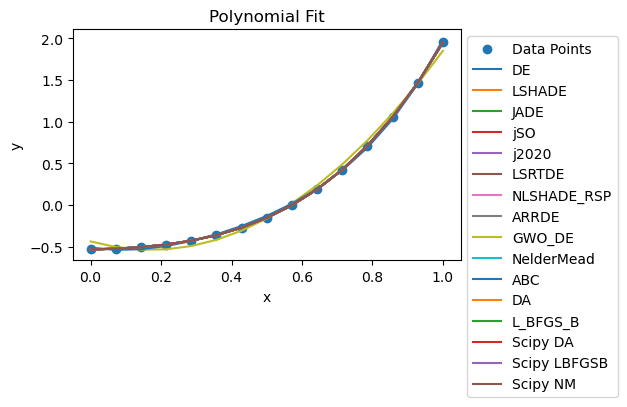

In [8]:
dimension=5 #the number of free parameters. The polynomial degree is just dimension-1
# Step 1: Generate data points from a polynomial 
np.random.seed(8)  # For reproducibility
# True coefficients of the polynomial (degree 10)
true_coefficients = [np.random.uniform(-1.0, 1.0)*1.0**i for i in range(dimension)]  # Random coefficients for the polynomial

# Generate dimension+10 data points
x_data = np.linspace(0.0, 1, dimension+10)
y_data = (np.polyval(true_coefficients, x_data))

# Step 2: Define the polynomial model
def polynomial_model(x, coefficients):
    """Given x and coefficients, return the polynomial value."""
    return (np.polyval(coefficients, x))

# Step 3: Define the objective function to minimize
def objective_function(coefficients):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = polynomial_model(x_data, coefficients)
    return np.mean((y_data - y_pred)**2)

def objective_function_vect(X) : 
    return [objective_function(x) for x in X ]


bounds= [(-10, 10)]*dimension
Nmaxeval= 10000
algos = ["DE","LSHADE", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP", "ARRDE", "GWO_DE", "NelderMead", "ABC", "DA", "L_BFGS_B"] #here, DA is dual annealing, ABC=artificial bee colony

# Step 4: Minimize the obj function and plot the results
plt.figure(figsize=(5,3))
plt.scatter(x_data, y_data, label='Data Points')

x0 = [0.0 for _ in range(dimension)]
for algo in algos : 
    res = mpy.Minimizer(objective_function_vect, bounds, x0=x0, relTol=0.0, algo = algo, maxevals=Nmaxeval, callback=None, seed=0, options={"population_size": 0}).optimize()
    print(algo , " : ", res.fun)
    plt.plot(x_data, polynomial_model(x_data, res.x ), label=algo)

dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval, no_local_search=False)
print("Scipy Dual Annealing (DA) : ", dual_ann.fun)
plt.plot(x_data, polynomial_model(x_data, dual_ann.x ), label="Scipy DA")

res = minimize(objective_function, x0 = x0, bounds=bounds, method="L-BFGS-B", options={"maxfun": Nmaxeval} )
print("Scipy LBFGSB : ", res.fun)
plt.plot(x_data, polynomial_model(x_data, res.x ), label="Scipy LBFGSB")

res = minimize(objective_function, x0 = x0, bounds=bounds, method="Nelder-Mead", options={"maxfev": Nmaxeval, "adaptive":True} )
print("Scipy Nelder-Mead : ", res.fun)
plt.plot(x_data, polynomial_model(x_data, res.x ), label="Scipy NM")

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


## Gaussian Mixture Model Fitting Problems

Thsi time, the model is given by the sum of Gaussian functions:
$$
    f(x, a, b, c) = \sum_{j=1}^{D/3} \frac{a_j}{\sum_{k=1}^{D/3} a_k} \frac{1}{b_j \sqrt{2\pi}} \exp\left[-\frac{1}{2} \frac{(x-c_j)^2}{b_j^2}\right]
$$
Here, $f(x, a, b, c)$ is normalized to represent a probability distribution. The data points are generated using predefined values of $a_j$, $b_j$, and $c_j$ within the interval $x \in [-20, 20]$. The objective function is the same as in the case of polynomial fitting. 


DE  :  0.0001292015957573507
LSHADE  :  0.0035781670432331204
JADE  :  0.007495833065561136
jSO  :  0.002473399446614842


/tmp/ipykernel_2486005/160663011.py:12: RuntimeWarning: divide by zero encountered in divide
  return (1.0/2.0*np.pi*width**2)*0.5  * np.exp(-((x - center) ** 2) / (2 * width ** 2))
/tmp/ipykernel_2486005/160663011.py:12: RuntimeWarning: invalid value encountered in divide
  return (1.0/2.0*np.pi*width**2)*0.5  * np.exp(-((x - center) ** 2) / (2 * width ** 2))


j2020  :  0.0016798057584839032
LSRTDE  :  0.00031837789464546546
NLSHADE_RSP  :  0.0008584023453707143
ARRDE  :  2.4855082149476883e-07
GWO_DE  :  0.004533471751249411
NelderMead  :  8.918211114113338e-06
ABC  :  0.003939588939874919
DA  :  2.4571593473890566e-06
L_BFGS_B  :  0.06829663540206003
Scipy LBFGSB :  0.06829643467175896
 Scipy Dual Annealing :  5.848370567089095e-06
Scipy Nelder-Mead :  0.0004963950951815175


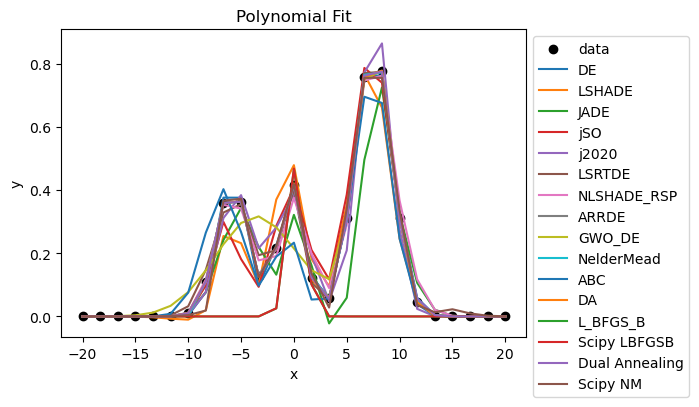

In [10]:
np.random.seed(5)  # For reproducibility

num_gauss = 5
true_centers = 10*(-1+2*np.random.random(num_gauss))
true_widths = np.random.rand(num_gauss) + 1.0  # Widths (variances)
true_coeffs = 2.0*np.random.rand(num_gauss)
dimension= num_gauss*3

# Define a Gaussian function
def gauss(x, center, width):
    """Compute a Gaussian RBF value given x, center, and width."""
    return (1.0/2.0*np.pi*width**2)*0.5  * np.exp(-((x - center) ** 2) / (2 * width ** 2))

# Define the function as a weighted sum of gaussians
def gmm(x, centers, widths, coeffs):
    result = np.zeros_like(x)
    coeffs= np.array(coeffs)
    norm_coeff = coeffs/np.sum(coeffs)
    for i in range(len(centers)):
        result += norm_coeff[i] * gauss(x, centers[i], widths[i])
    return result


# Generate dimension+10 data points
x_data = np.linspace(-20, 20,dimension+10)
y_data = gmm(x_data, true_centers, true_widths, true_coeffs)

# Step 2: Define the model for fitting
def gmm_model(x, params):
    """ model with combined parameters (centers, widths, and coefficients)."""
    num_gauss = len(params) // 3
    centers = params[:num_gauss]
    widths = params[num_gauss:2*num_gauss]
    coeffs = params[2*num_gauss:]
    return gmm(x, centers, widths, coeffs)

# Step 3: Define the objective function to minimize
def objective_function(params):
    """Objective function for optimization: Sum of squared errors."""
    y_pred = gmm_model(x_data, params)
    return np.mean((y_data - y_pred) ** 2)


executor = concurrent.futures.ThreadPoolExecutor(max_workers=8)
def objective_function_vect(params) : 
    ret = list(executor.map(objective_function, params))
    return ret


bounds= [(-10, 10)]*dimension
Nmaxeval=10000
algos = ["DE","LSHADE", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP", "ARRDE", "GWO_DE", "NelderMead", "ABC", "DA", "L_BFGS_B"]
x0 = [1.0 for _ in range(dimension)]

plt.figure(figsize=(6,4))
plt.scatter(x_data, y_data, label="data", color="black")
for algo in algos : 
    res = mpy.Minimizer(objective_function_vect, bounds, x0=x0, relTol=0.0, algo = algo, maxevals=Nmaxeval, callback=None, seed=None, options={"population_size": 0}).optimize()
    print(algo , " : ", res.fun)
    plt.plot(x_data, gmm_model(x_data, res.x ), label=algo)

res = minimize(objective_function, x0 = x0, bounds=bounds, method="L-BFGS-B", options={"maxfun": Nmaxeval} )
print("Scipy LBFGSB : ", res.fun)
plt.plot(x_data, gmm_model(x_data, res.x ), label="Scipy LBFGSB")


dual_ann = dual_annealing(objective_function, bounds, maxfun=Nmaxeval, no_local_search=False)
print(" Scipy Dual Annealing : ", dual_ann.fun)
plt.plot(x_data, gmm_model(x_data, dual_ann.x ), label="Dual Annealing")

res = minimize(objective_function, x0 = x0, method="Nelder-Mead", options={"maxfev": Nmaxeval, "adaptive":True} )
print("Scipy Nelder-Mead : ", res.fun)
plt.plot(x_data, gmm_model(x_data, res.x ), label="Scipy NM")


plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Polynomial Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

executor.shutdown()


## More complex fitting problem: CT18 PDFs Fitting

Here, we provide a slightly more challenging curve fitting problem. The task is to reproduce the CT18 parton distribution functions (PDFs) \cite{Hou:2019efy}. The parameterization for valence up-quark ($u_v$), valence down-quark ($d_v$), gluon, anti-$u$ ($\bar{u}$), anti-$d$ ($\bar{d}$), and strange quark ($s$) PDFs at the initial scale is given by:
$$
    f_i(x) = a_0 x^{a_1-1} (1-x)^{a_2} P_i(y, a_3, a_4, \dots), \quad i \in \{u_v, d_v, g, \bar{u}, \bar{d}, s\}
$$
Here, $P_i(y)$ is a Bernstein polynomial of degree 4, 3, or 5, depending on the specific PDF. The variable $y$ is defined as $y = \sqrt{x}$ for $u_v$, $d_v$, and $g$, and as $y = (1 - (1 - \sqrt{x}))^{a_3}$ for the sea quarks. The objective function is:
$$
    L = \sum_i \frac{1}{N} \sum_{j=1}^N \left(y_j - f_i(x_j)\right)^2
$$
where $i \in \{u_v, d_v, g, \bar{u}, \bar{d}, s\}$. The dimensionality of this problem is $D = 47$.


In [11]:
class CT18PDFs : 
    def __init__(self) : 
        self.parameters = {
            "uv_0" : 3.385, "uv_1" : 0.763, "uv_2" : 3.036, "uv_3" : 1.502, "uv_4" : -0.147,"uv_5" : 1.671, "uv_6" : 0.,
            "dv_0" : 0.490, "dv_1" : 0.763, "dv_2" : 3.036, "dv_3" : 2.615, "dv_4" : 1.828,"dv_5" : 2.721, "dv_6" : 0., 
            "g_0" : 2.690, "g_1" : 0.531, "g_2" : 3.148, "g_3" : 3.032, "g_4" : -1.705, "g_5" : 1.354, 
            "ubar_0" : 0.414, "ubar_1" : -0.022, "ubar_2" : 7.737, "ubar_3" : 4.0, "ubar_4" : 0.618,"ubar_5" : 0.195, "ubar_6" : 0.871, "ubar_7" : 0.267,"ubar_8" : 0.733,
            "dbar_0" : 0.414, "dbar_1" : -0.022, "dbar_2" : 7.737, "dbar_3" : 4.0, "dbar_4" : 0.292,"dbar_5" : 0.647, "dbar_6" : 0.474, "dbar_7" : 0.741,"dbar_8" :1.0,
            "s_0" : 0.288, "s_1" : -0.022, "s_2" : 10.31, "s_3" : 4.0, "s_4" : 0.466,"s_5" : 0.466, "s_6" : 0.225, "s_7" : 0.225,"s_8" : 1.0,
        }
        self.xlist = np.linspace(1e-3, 0.8, 50)
        self.paramNames = list(self.parameters.keys())
        self.originalData = self.getData()

    def uv(self, x) : 
        a0 = self.parameters["uv_0"]
        a1 = self.parameters["uv_1"]
        a2 = self.parameters["uv_2"]
        a3 = self.parameters["uv_3"]
        a4 = self.parameters["uv_4"]
        a5 = self.parameters["uv_5"]
        a6 = self.parameters["uv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dv(self, x) : 
        a0 = self.parameters["dv_0"]
        a1 = self.parameters["dv_1"]
        a2 = self.parameters["dv_2"]
        a3 = self.parameters["dv_3"]
        a4 = self.parameters["dv_4"]
        a5 = self.parameters["dv_5"]
        a6 = self.parameters["dv_6"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**4 + np.sinh(a4) *4*y*(1-y)**3 + np.sinh(a5) *6*y**2*(1-y)**2 + np.sinh(a6) *4*y**3*(1-y) + y**4
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def g(self, x) : 
        a0 = self.parameters["g_0"]
        a1 = self.parameters["g_1"]
        a2 = self.parameters["g_2"]
        a3 = self.parameters["g_3"]
        a4 = self.parameters["g_4"]
        a5 = self.parameters["g_5"]
        y= np.sqrt(x)
        P = np.sinh(a3)*(1-y)**3 + np.sinh(a4) *3*y*(1-y)**2 + np.sinh(a5) *3*y**2*(1-y)  + y**3
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def ubar(self, x) : 
        a0 = self.parameters["ubar_0"]
        a1 = self.parameters["ubar_1"]
        a2 = self.parameters["ubar_2"]
        a3 = self.parameters["ubar_3"]
        a4 = self.parameters["ubar_4"]
        a5 = self.parameters["ubar_5"]
        a6 = self.parameters["ubar_6"]
        a7 = self.parameters["ubar_7"]
        a8 = self.parameters["ubar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def dbar(self, x) : 
        a0 = self.parameters["dbar_0"]
        a1 = self.parameters["dbar_1"]
        a2 = self.parameters["dbar_2"]
        a3 = self.parameters["dbar_3"]
        a4 = self.parameters["dbar_4"]
        a5 = self.parameters["dbar_5"]
        a6 = self.parameters["dbar_6"]
        a7 = self.parameters["dbar_7"]
        a8 = self.parameters["dbar_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def s(self, x) : 
        a0 = self.parameters["s_0"]
        a1 = self.parameters["s_1"]
        a2 = self.parameters["s_2"]
        a3 = self.parameters["s_3"]
        a4 = self.parameters["s_4"]
        a5 = self.parameters["s_5"]
        a6 = self.parameters["s_6"]
        a7 = self.parameters["s_7"]
        a8 = self.parameters["s_8"]
        y= 1-(1-np.sqrt(x))**a3
        P = (1-y)**5 + a4 * 5*y*(1-y)**4 + a5 * 10*y**2*(1-y)**3 +  a6 * 10*y**3*(1-y)**2 +  a7 * 5*y**4*(1-y)+  a8 * 5*y**5
        return a0 * x**(a1-1)*(1-x)**a2*P
    
    def u(self, x) : return self.uv(x)+self.ubar(x)
    def d(self, x) : return self.dv(x)+self.dbar(x) 

    def setParameter(self, pars) : 
        assert(len(pars)==len(self.parameters)) 
        self.parameters= dict(zip(self.paramNames, pars))

    def getData(self) : 
        x= self.xlist
        return [ x*self.u(self.xlist), x*self.ubar(self.xlist), x*self.d(self.xlist), x*self.dbar(self.xlist), x*self.g(self.xlist), x*self.s(self.xlist)]
    
    def chi2(self, params) : 
        self.setParameter(params) 
        data = self.getData() 
        ret =0
        for do, d in zip(self.originalData, data) : 
            ret = ret + np.sum((do-d)**2)
        return ret 
    
    def chi2_vect(self, params, data=None) : 
        return [self.chi2(p) for p in params ]

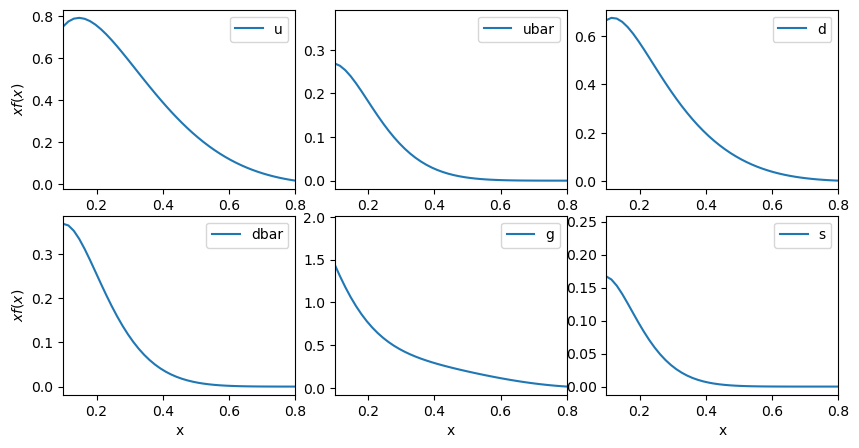

In [12]:
ct18 = CT18PDFs()
data = ct18.getData()

# Create a 3x2 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

# List of labels for each plot
labels = ["u", "ubar", "d", "dbar", "g", "s"]

# Plotting each function in its corresponding subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(ct18.xlist, data[i], label=labels[i])
    ax.set_xlim(0.1, 0.8)
    ax.set_xlabel("x")
    if (i%3 == 0):
        ax.set_ylabel(r"$xf(x)$")
    ax.legend()
plt.subplots_adjust(hspace=0.15, wspace=0.17)
plt.show()


Dimension :  47
	Obj  DE  :   2.5145084670797493
	Obj  LSHADE  :   18.111441778498257
	Obj  JADE  :   14.392827982454865
	Obj  jSO  :   6.982142160300295
	Obj  j2020  :   18.706918172950736
	Obj  LSRTDE  :   10.899502149299106
	Obj  NLSHADE_RSP  :   6.393415140808911
	Obj  ARRDE  :   1.2519817845657744
	Obj  GWO_DE  :   1.6873775808710876
	Obj  NelderMead  :   31.34249076364488
	Obj  ABC  :   70.84969715476645
	Obj  DA  :   1.205985850568982
	Obj  L_BFGS_B  :   0.10053359961978563
	Obj  Scipy L-BFGS-B  :   0.0783844989639361
	Obj  Scipy DA  :   1.6529183860856411


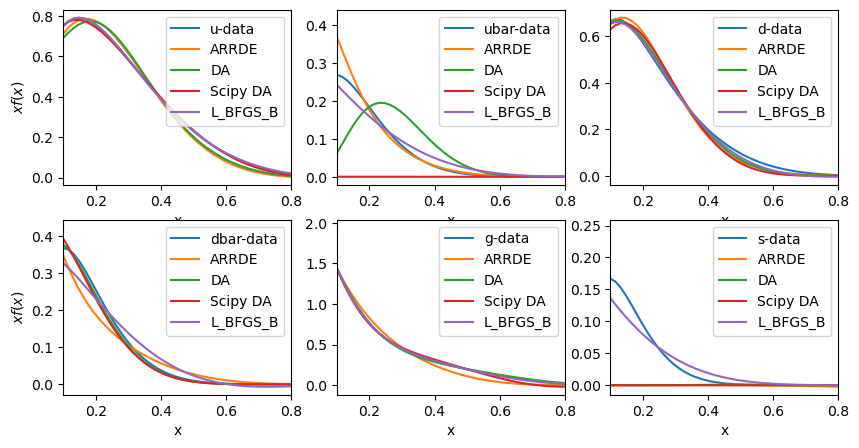

In [14]:
dimension = 47
print("Dimension : ", dimension)
bounds= [(-10, 10)]*dimension
Nmaxeval=20000
x0 = [1.0 for _ in range(dimension)]

algos = ["DE","LSHADE", "JADE", "jSO", "j2020", "LSRTDE", "NLSHADE_RSP", "ARRDE", "GWO_DE", "NelderMead", "ABC", "DA", "L_BFGS_B"]
#algos = ["ARRDE", "DA",  "L_BFGS_B"]

results = {}
for algo in algos :
    res = mpy.Minimizer(ct18.chi2_vect,bounds, x0=x0,algo=algo, relTol=0.0,  maxevals=Nmaxeval, callback=None, seed=None, options={"population_size": 0} ).optimize()
    print("\tObj ", algo, " :  ", res.fun)
    results[algo] = res

res = minimize(ct18.chi2, x0=x0, bounds=bounds, options={"maxfun": Nmaxeval})
print("\tObj ", "Scipy L-BFGS-B", " :  ", res.fun)
results["Scipy L-BFGS-B"] = res

dual_ann = dual_annealing(ct18.chi2, bounds, maxfun=Nmaxeval, no_local_search=False)
print("\tObj ", "Scipy DA", " :  ", dual_ann.fun)
results["Scipy DA"] = dual_ann

fig, axes = plt.subplots(2, 3, figsize=(10, 5))
labels = ["u-data", "ubar-data", "d-data", "dbar-data", "g-data", "s-data"]

# Plotting each function in its corresponding subplot
for i, ax in enumerate(axes.flatten()):
    ax.plot(ct18.xlist, data[i], label=labels[i])
    for algo in ["ARRDE", "DA", "Scipy DA",  "L_BFGS_B"] : 
        ct18.setParameter(results[algo].x)
        theo = ct18.getData()
        ax.plot(ct18.xlist, theo[i], label=algo)
    ax.set_xlim(0.1, 0.8)
    ax.set_xlabel("x")
    if (i%3 == 0):
        ax.set_ylabel(r"$xf(x)$")
    ax.legend()
